### Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim
import emcee
import corner

## 1. Random gaussian "noise"
Read data from `true_values.txt` and add the gaussian displacement

In [3]:
# read file 
c1, ceq = np.loadtxt('true_values.txt', unpack = True)

# add gaussian displacement
c1_bar = np.array(c1 + [np.random.normal(0,0.5) for i in range(len(c1))])
ceq_bar = np.array(ceq + [np.random.normal(0,0.5) for i in range(len(ceq))])

# check the right number of elements
print( len(c1) == len(c1_bar) == len (ceq) == len(ceq_bar) )

True


Store new data in output named `offset.dat`

In [4]:
# open new file
fh = open('offset.dat', 'w')

# columns name
fh.write('c1_tilde\tc_equivalent_tide\n')

# store data
for i in range(len(c1)):
    fh.write('{0}\t{1}\n'.format(c1_bar[i],ceq_bar[i]))
    
# close file
fh.close()

## 2. Fit of the function
Definition of the function's model:
$$f(x) = \frac{1}{ \frac{1}{x+a} + b }$$

In [5]:
# model
def f(x, a, b):
    return 1/(b + 1/(x+a))

# prepare x array to plot the fitted function
x = np.arange(1,100,0.01)

Fit of the data and print the results

In [6]:
# fit the function from data
#   "true" values
true_parameters, true_convariance = optim.curve_fit(f,c1,ceq)
#   fitted values
parameters, convariance = optim.curve_fit(f,c1_bar,ceq_bar)


#print the results
print("Results of the fit:\na = {0} +/- {1}\n b = {2} +/- {3}".format( parameters[0], convariance[0][0], parameters[1], convariance[1][1] ) )

# assign true and fitted parameters to variables
true_a = true_parameters[0]
true_b = true_parameters[1]
fitted_a = parameters[0]
fitted_b = parameters[1]

Results of the fit:
a = 9.95291181467464 +/- 0.02173530601854764
 b = 0.05543569635747253 +/- 9.732299059222145e-09


Plot of the results

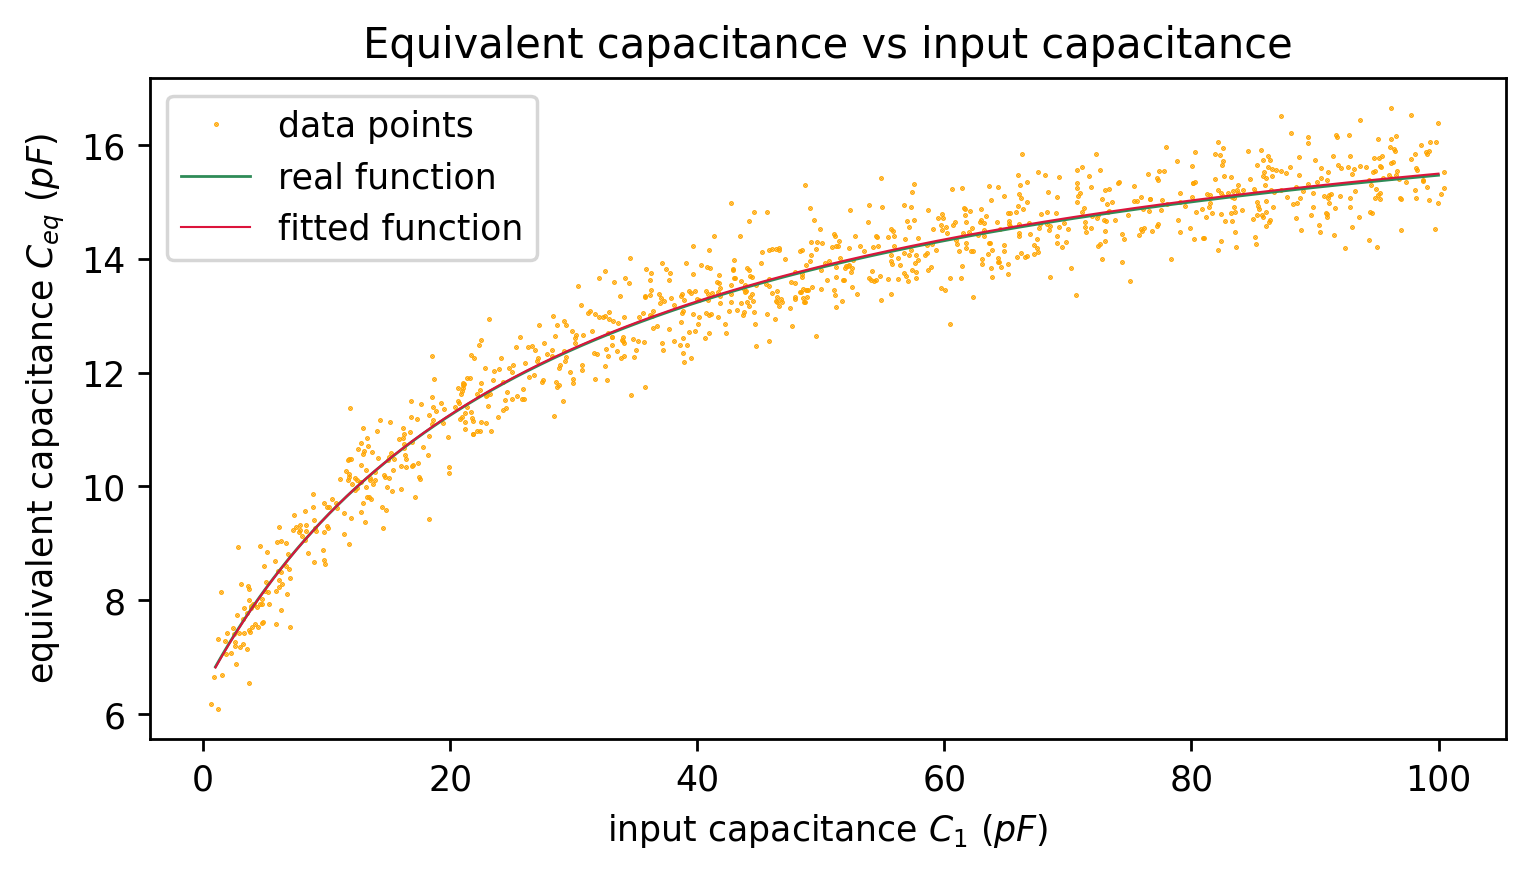

In [7]:
# to ensure the view of the plot in Google Colab
%matplotlib inline

# preset of the figure
plt.figure('first_fit', facecolor='white', figsize = (7,3.5), dpi = 250)

# plot + options
plt.plot(c1_bar, ceq_bar, label='data points', marker='.', markersize=0.8, color='orange', lw=0)
plt.plot(x, f(x, true_a, true_b), label="real function", color='seagreen', lw = 0.8)
plt.plot(x, f(x, fitted_a, fitted_b), label="fitted function", color='crimson', lw = 0.6)
plt.title('Equivalent capacitance vs input capacitance')
plt.xlabel('input capacitance $C_1$ $(pF)$')
plt.ylabel('equivalent capacitance $C_{eq}$ $(pF)$')
plt.legend()
# plt.show()

# save the figure
plt.savefig("./fit.png")

## 3. Generation of $\Delta C_{eq}$

Random gaussian errors with $\sigma = 3$ (pF) for both $C_1$ and $C_{eq}$

In [8]:
true_f = 3.0
ceq_err = np.array([np.random.normal(0,true_f) for i in range(len(ceq))])

# check that c1 and ceq_err have the right number of elements
print(len(c1) == len(ceq_err) == len(ceq))

True


Store in output file named `errorbar.dat`:

In [9]:
# open an output file in write mode
outputname = 'errorbar.dat'
fh = open(outputname, 'w')

# columns name
fh.write('C_equivalent\tDeltaC_equivalent\n')

# store data
for i in range(len(c1)):
    fh.write('{0}\t\t\t\t{1}\n'.format(ceq[i],ceq_err[i]))
    #check
    #print('{0}\t\t\t\t{1}'.format(c1_err[i],ceq_err[i]))

# close the file
print("Data stored in \'" + outputname + "\'")
fh.close()

Data stored in 'errorbar.dat'


## 4. Monte Carlo
Definitions of probability densitiy funcions:
$$\ln p(a,b|C_1,C_{eq}, \Delta C_{eq}) = \ln \mathcal{L} (C_1,C_{eq}, \Delta C_{eq}|a,b) + \ln \pi (a,b) $$
where we altready know how $\mathcal{L}$ is made and we assume $\ln \pi$ as a uniform disrtribution for:
- $a \in [6,14]$
- $b \in [-1,1]$
Set these probability distributions

In [10]:
# model of ln(Likelihood)
def log_likelihood(theta, x, y, dy):
    a, b = theta
    sigma2 = dy**2
    return -0.5*np.sum((y - f(x, a, b))**2/sigma2 + np.log(2*np.pi*sigma2))
    
# uniform ln(\pi)
def log_prior(theta):
    a, b = theta
    if 6 < a < 14 and -1.0 < b < 1.0:
        return 0.0
    return -np.inf

# posterior model from Bayes theorem (not normalized)
def log_probability(theta, x, y, dy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, dy)

Presettings for Monte Carlo simulation

In [12]:
# number of walkers
number_walkers = 32

# number of parameters to fit ()
n_parameters = 2

# number of steps
number_steps = 10000

# initial points for parameters (for each walker)
true_log_f = -np.log(true_f)
#   choose the previous parameters + a little deviation
initial_parameters = [fitted_a, fitted_b] + 1e-3*np.random.randn(number_walkers, n_parameters)

Run the Monte Carlo sampler via `emcee`. I choose $N_{walk.} = 32$ walkers and a number of step $N_{step} = 10^4$.

In [13]:
# set the sampler
sampler = emcee.EnsembleSampler(number_walkers, n_parameters, log_probability, args=(c1_bar, ceq, ceq_err))

# run the sampler
sampler.run_mcmc(initial_parameters, number_steps, progress=True);

100%|██████████| 10000/10000 [00:24<00:00, 412.42it/s]


#### Look at the results of `emcee` Monte Carlo sampling

A brief look at the sampling chain

Text(0.5, 0, 'MCMC step')

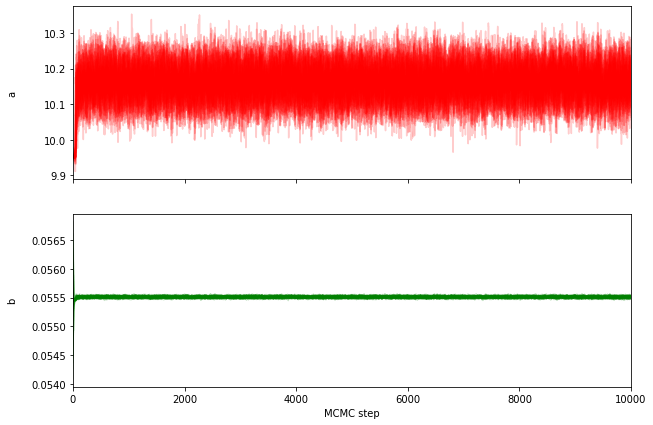

In [14]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
col = ['r', 'g']
for i in range(n_parameters):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step")

#### Corner plot of the posterior distributions of parameters $\vec\theta = (a,b)$

(21120, 2)


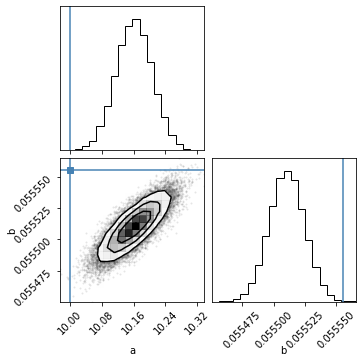

In [16]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, truths=[true_parameters[0], true_parameters[1]])